## Habilitar el acceso de IMAP y generar credenciales



In [1]:
import imaplib #Importamos las librerias correspondientes 
import email

from email.header import decode_header

import pandas as pd
from tqdm import tqdm #Esto para medir cuanto se demora en la extracion de los correos de Gmail

import numpy as np
from PIL import Image

import matplotlib.pyplot as alt 
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud, STOPWORDS


## Acceder a Gmail con las credenciales 

In [2]:
user, password ="juanea26a@gmail.com","uwgehkjnxyyfnksj"

imap_url='imap.gmail.com'
my_mail=imaplib.IMAP4_SSL(imap_url)
my_mail.login(user,password)

('OK', [b'juanea26a@gmail.com authenticated (Success)'])

In [3]:
# Seleccionamos los correos de la bandeja de entrada  
my_mail.select('Inbox')

('OK', [b'30100'])

In [4]:
total_correos = int(my_mail.select('Inbox')[1][0].decode('utf-8'))
total_correos

30100

## Paso 2: Obtener correos electronicos

In [5]:
arr=my_mail.fetch('3','(UID RFC822)')[1][0] #correos mapeados, la marca de UID hace referencia a la sintaxis 
#Obtenemos una tupla 
#Se coloca [][][] para acceder los elementos desados en esta tupla

email.message_from_string(str(arr[1],'utf-8'))['from'] # en esta parte podemos extraer los datos nesecarios, como en este caso quien lo envio

'YouTube <noreply@youtube.com>'

In [ ]:
email_df = pd.DataFrame(columns=['Date','From','Subject'], index=range(total_correos,0,-1))

for i in tqdm(range(total_correos, 0, -1)):
    data = my_mail.fetch(str(i),'(UID RFC822)')
    arr = data[1][0]
    if isinstance(arr, tuple):
        try: msg = email.message_from_string(str(arr[1],'utf-8'))
        except: msg = email.message_from_string(str(arr[1],'latin-1'))
        new_row = pd.Series({"Date":msg['Date'] , "From":msg['from'], "Subject":msg['subject']})
    email_df = email_df.append(new_row, ignore_index=True)
    
email_df = email_df.dropna(how='all').reset_index(drop=True) # Limpiar filas vacías
email_df

<h3>Creaciòn de un DateFrame</h3>

In [7]:
#Ponemos esl dataframe en un excel en una carpeta 
email_df.to_csv('C:/Users/user/Desktop/Data Analisis/email_df.csv', index=False, encoding='utf-8')

In [8]:
print(msg.keys())
#Nos pormetie que campos  extraer en en excel, sto lo podemos saber por que es una tupla 

['Delivered-To', 'Received', 'X-Received', 'Return-Path', 'Received', 'Received-SPF', 'Authentication-Results', 'Received', 'DKIM-Signature', 'X-Google-DKIM-Signature', 'X-Gm-Message-State', 'MIME-Version', 'X-Received', 'Reply-To', 'X-Google-Id', 'Feedback-ID', 'Message-ID', 'Date', 'Subject', 'From', 'To', 'Content-Type', 'X-Antivirus', 'X-Antivirus-Status']


<h3>Limpieza y Transformacion de datos</h3>

In [42]:
def limpiar_fecha(x):
    if ',' not in x:
        x = ', ' + x
    if '(' in x:
        x = ' '.join(x.split(' ')[:-1])
    x = ' '.join(x.split(' ')[:-1])
    return x

In [56]:
### Transformar Date "Wed, 14 Sep 2022 17:38:23 +0000 (UTC)" 
# Obtener columna 'H_M_S'
email_df['Date'] = email_df['Date'].apply(lambda x: limpiar_fecha(x)) # Se obtiene "Wed, 14 Sep 2022 17:38:23"
email_df['Date'] = email_df['Date'].str.split(', ').str[-1]           # Se obtiene "14 Sep 2022 17:38:23"
email_df['H_M_S'] = email_df['Date'].apply(lambda x: x[-8:])          # Se obtiene "17:38:23"

# Obtener columna 'Hour'
email_df['Hour'] = email_df['H_M_S'].apply(lambda x: x[:2]+'h-'+str(int(x[:2])+1).zfill(2)+'h')    # Se obtiene "17h-18h"

# Obtener columna 'Date'
email_df['Date'] = email_df['Date'].apply(lambda x: x[:-9] if len(x[:-9])==11 else '0'+x[:-9] )    # Se obtiene "14 Sep 2022"
email_df['Date'] = pd.to_datetime(email_df['Date'], format='%d %b %Y')                             # Se obtiene "2022-09-14"

# Obtener columna 'WeekDay'
email_df['WeekDay'] = email_df['Date'].dt.strftime('%A')                                        # Se obtiene "Wednesday"  

email_df.head()

,Date,H_M_S,Hour,Mail,Name,Subject,WeekDay
0,2023-10-06,09:04:02,09h-10h,hello@email.bing.com,Microsoft Bing,Noticias de tendencia: Ella es Leidy Johana Bu...,Friday
1,2023-10-06,10:55:58,10h-11h,Extractos@bancopopular.com.co,BANCO POPULAR S.A.,Extracto Tarjeta de Crédito Exprés - Octubre ...,Friday
2,2023-10-06,15:38:37,15h-16h,newsletters-noreply@linkedin.com,EY via LinkedIn,5 cyber must reads for the weekend,Friday
3,2023-10-06,15:01:23,15h-16h,info@premiumkpi.com,Rosa Aminta Salazar,Es una especie de cosa emo,Friday
4,2023-10-06,07:25:02,07h-08h,businessprofile-noreply@google.com,Google Business Profile,"TEXTILES MONTEX, aquí está tu informe de rendi...",Friday


In [57]:
# Obtener columna 'WeekDay'
email_df['WeekDay'] = email_df['Date'].dt.strftime('%A')     

<h3>Columna From y subject</h3>

In [58]:
def obtener_correo_de_from(x):
    x_mod = x.split('<')[-1].split('>')[0]
    return x_mod

def obtener_nombre_de_from(x):
    text, encoding = decode_header(x)[0]
    if not encoding and isinstance(text, str):
        text = ' '.join(text.split(' ')[:-1])
    else:
        text = text.decode('utf-8', errors='ignore')
        
    text = text.replace('"', '')
    return text

def limpiar_subject(x):
    if x:
        text, encoding = decode_header(x)[0]
        try: text = text.decode('utf-8', errors='ignore')
        except: pass
    else: text=x
    return text

In [60]:
email_df['Mail'] = email_df['From'].apply(lambda x: obtener_correo_de_from(x))
email_df['Name'] = email_df['From'].apply(lambda x: obtener_nombre_de_from(x))
email_df['Subject'] = email_df['Subject'].apply(lambda x: limpiar_subject(x))
email_df = email_df.drop(columns=['From'])[['Date','H_M_S','Hour','Mail','Name','Subject']]
email_df.head()

,Date,H_M_S,Hour,Mail,Name,Subject,WeekDay
0,2023-10-06,09:04:02,09h-10h,hello@email.bing.com,Microsoft Bing,Noticias de tendencia: Ella es Leidy Johana Bu...,Friday
1,2023-10-06,10:55:58,10h-11h,Extractos@bancopopular.com.co,BANCO POPULAR S.A.,Extracto Tarjeta de Crédito Exprés - Octubre ...,Friday
2,2023-10-06,15:38:37,15h-16h,newsletters-noreply@linkedin.com,EY via LinkedIn,5 cyber must reads for the weekend,Friday
3,2023-10-06,15:01:23,15h-16h,info@premiumkpi.com,Rosa Aminta Salazar,Es una especie de cosa emo,Friday
4,2023-10-06,07:25:02,07h-08h,businessprofile-noreply@google.com,Google Business Profile,"TEXTILES MONTEX, aquí está tu informe de rendi...",Friday


In [61]:
email_df.to_csv('C:/Users/user/Desktop/Data Analisis/email_final.csv', quotechar='"', sep='|', index=False, encoding='utf-8')
#Guardamos nuestro DataFrame Final en una carpeta nuestra 

<h3> Paso 4: Plotear Word Cloud de los asuntos de los correos (columna Subject) </h3>

In [62]:
# Escalar de 0 a 1 los valores RGB
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

# Asignar colores del logo de Gmail
# guinda (197,34,31), verde (52,168,83), azul (66,133,244), rojo (234,67,53), amarillo (251,188,4)
cdict = {'red':((0.0,inter_from_256(197),inter_from_256(197)),
               (1/5*1,inter_from_256(52),inter_from_256(52)),
               (1/5*3,inter_from_256(66),inter_from_256(66)),
               (1/5*4,inter_from_256(234),inter_from_256(234)),
               (1.0,inter_from_256(251),inter_from_256(251))),
        'green':((0.0, inter_from_256(34), inter_from_256(34)),
               (1/5*1, inter_from_256(168), inter_from_256(168)),
               (1/5*3, inter_from_256(133), inter_from_256(133)),
               (1/5*4, inter_from_256(67), inter_from_256(67)),
               (1.0, inter_from_256(188), inter_from_256(188))),
        'blue':((0.0, inter_from_256(31), inter_from_256(31)),
               (1/5*1, inter_from_256(83), inter_from_256(83)),
               (1/5*3, inter_from_256(244), inter_from_256(244)),
               (1/5*4, inter_from_256(53), inter_from_256(53)),
               (1.0, inter_from_256(4), inter_from_256(4))),}

# Crear paleta customizada de colores
gmail = LinearSegmentedColormap('gmail',segmentdata=cdict)

<h3> Paso 5: Plotear Word Cloud de los nombres de los correos (columna Name) </h3>

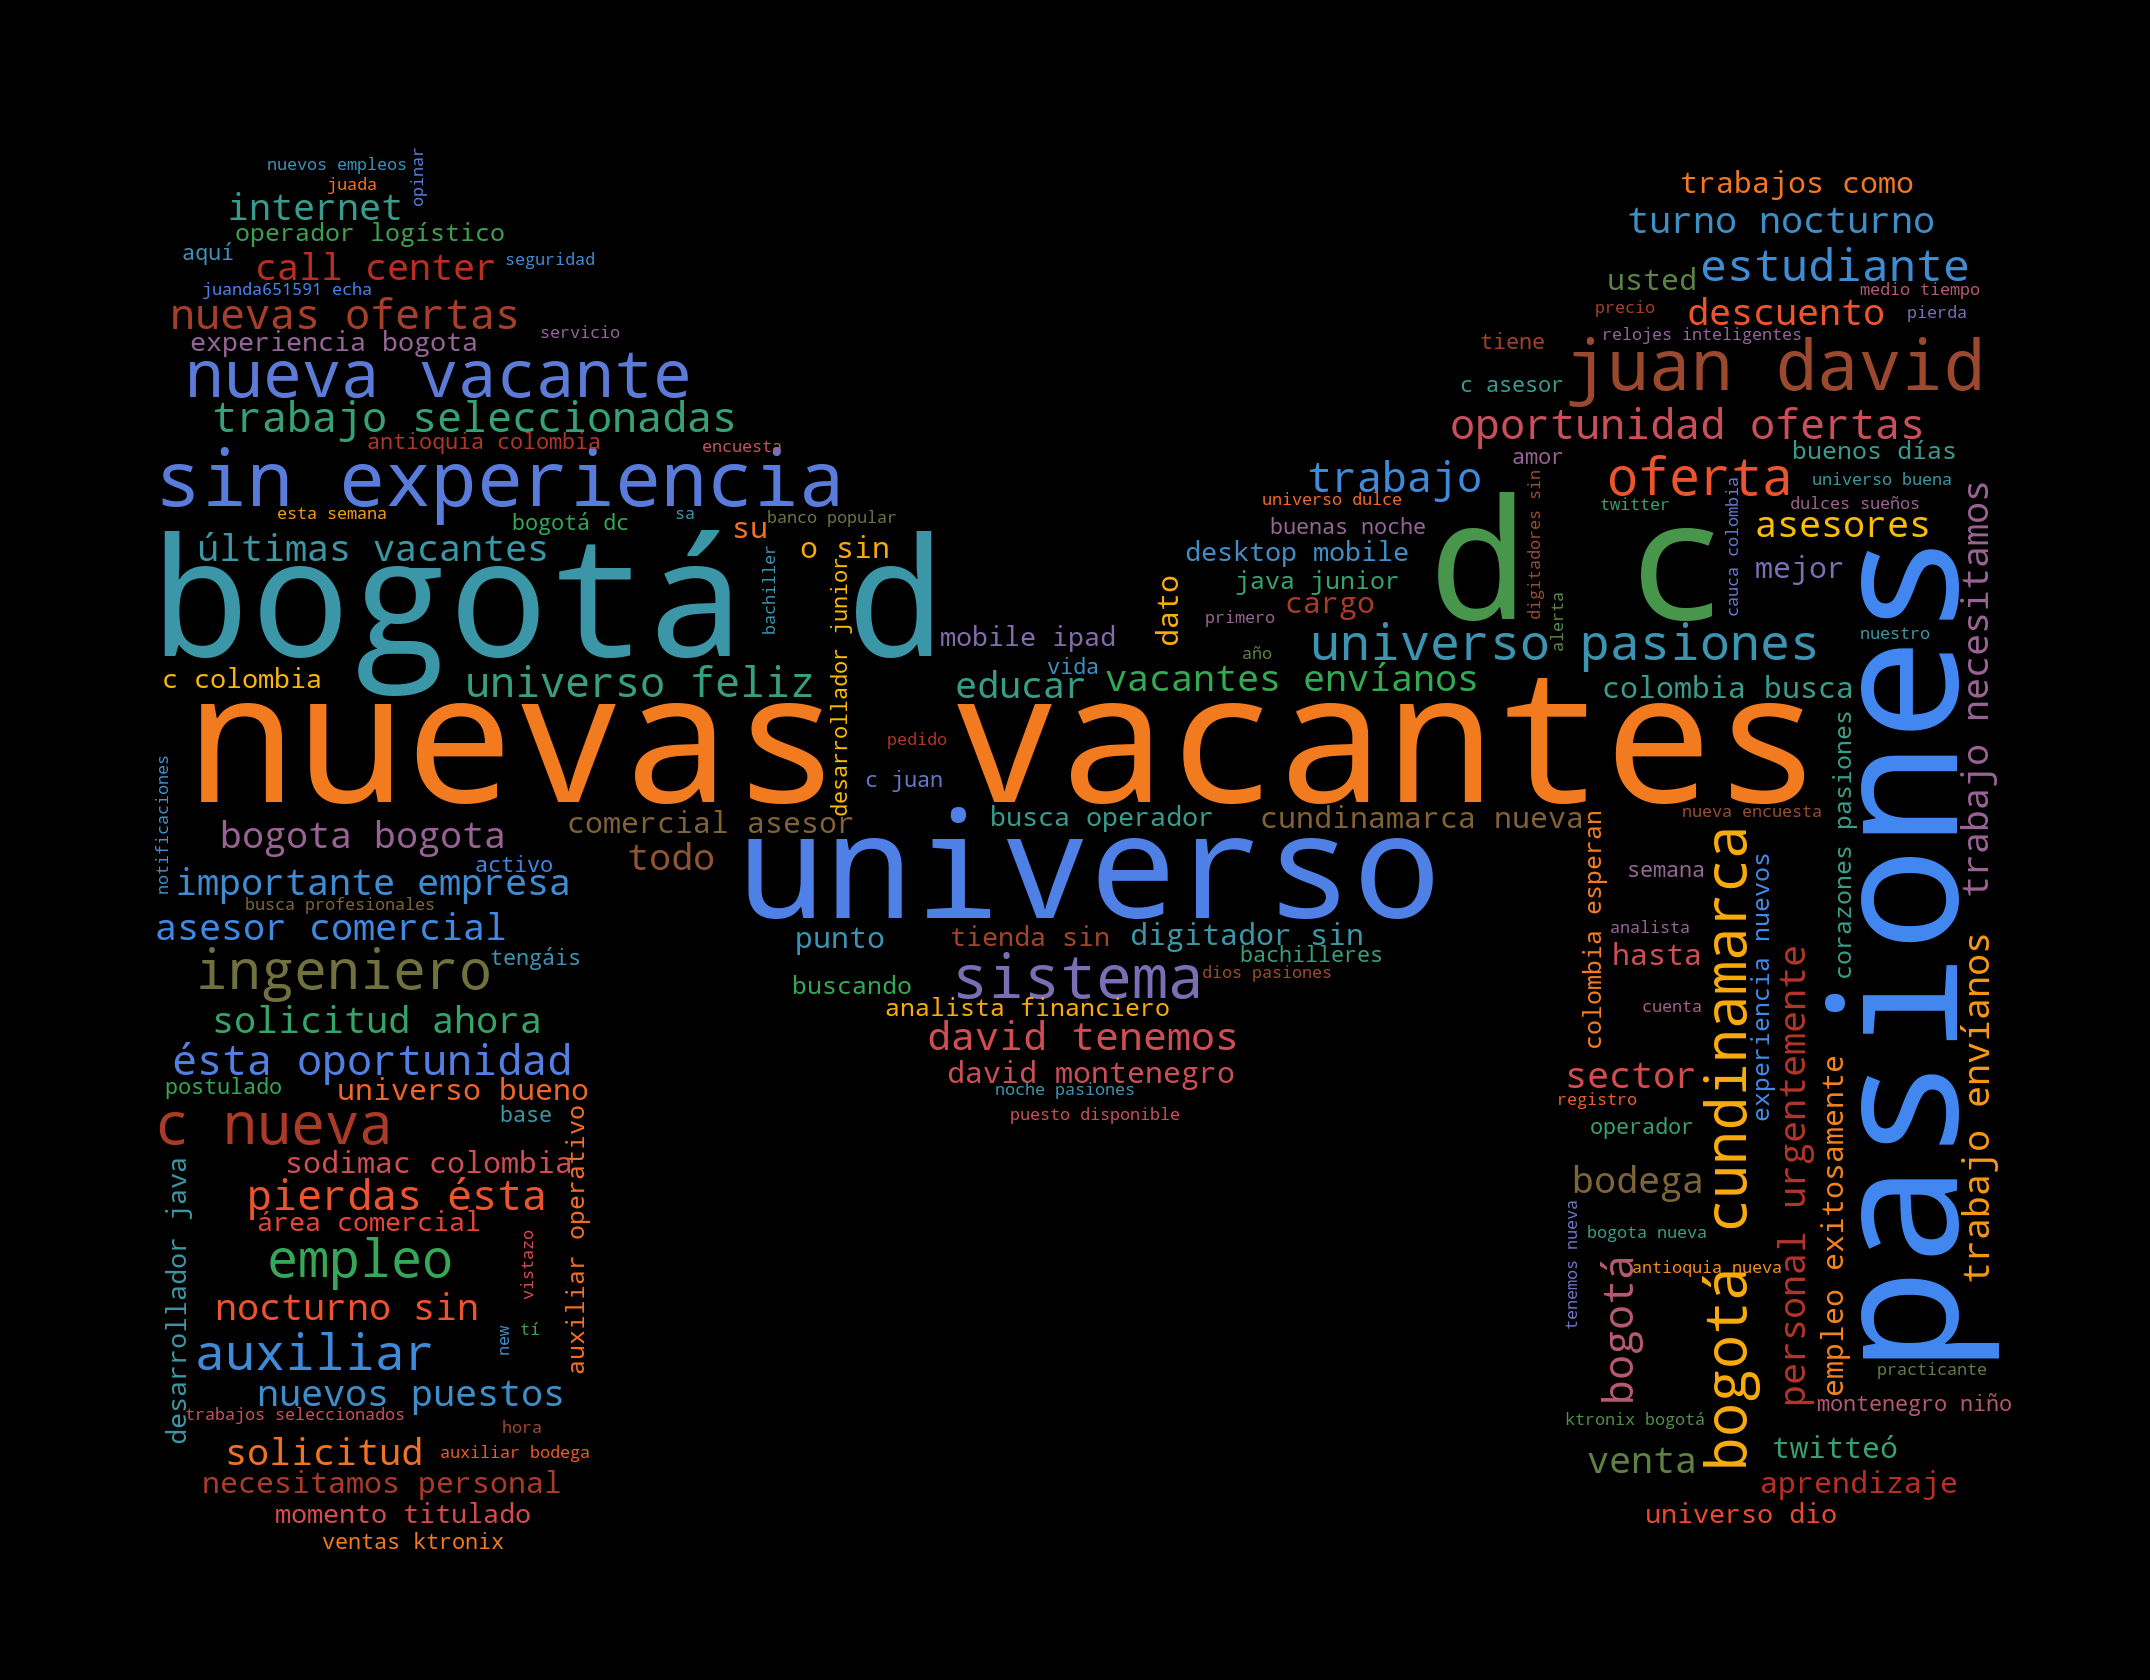

In [65]:
# Crear un string que contendrá todas las palabras
total_subjects = ' '
stopwords = STOPWORDS.update(['al','de','en','tu','s','la','y','que','te','lo','el','la','solo','del','por','qué','que','ha','desde',
                             'por','ya','más','es','con','tus','para','se','los','un','una','las','esto','va','sobre','ti','los',
                             'sandro','agama','está','tienes notificaciones','este','día','hola','hoy'])
mask = np.array(Image.open('C:/Users/user/Desktop/Data Analisis/gmail.jpg'))

# Obtener y acumular todas los subjects de los correos
for mensaje in email_df['Subject'].values:
    subjects = str(mensaje).lower().split() # Obtener las palabras en minúscula de cada subject
    for subject in subjects:
        total_subjects = total_subjects + subject + ' ' # Acumular todas los subjects

wordcloud = WordCloud(scale=2.5, width = 1000, height = 800, 
                      background_color ='black',
                      mask = mask,
                      colormap=gmail,
                      stopwords = stopwords, 
                      min_font_size = 6).generate(total_subjects) 

# Plotear la nube de palabras más usadas
wordcloud.to_image()

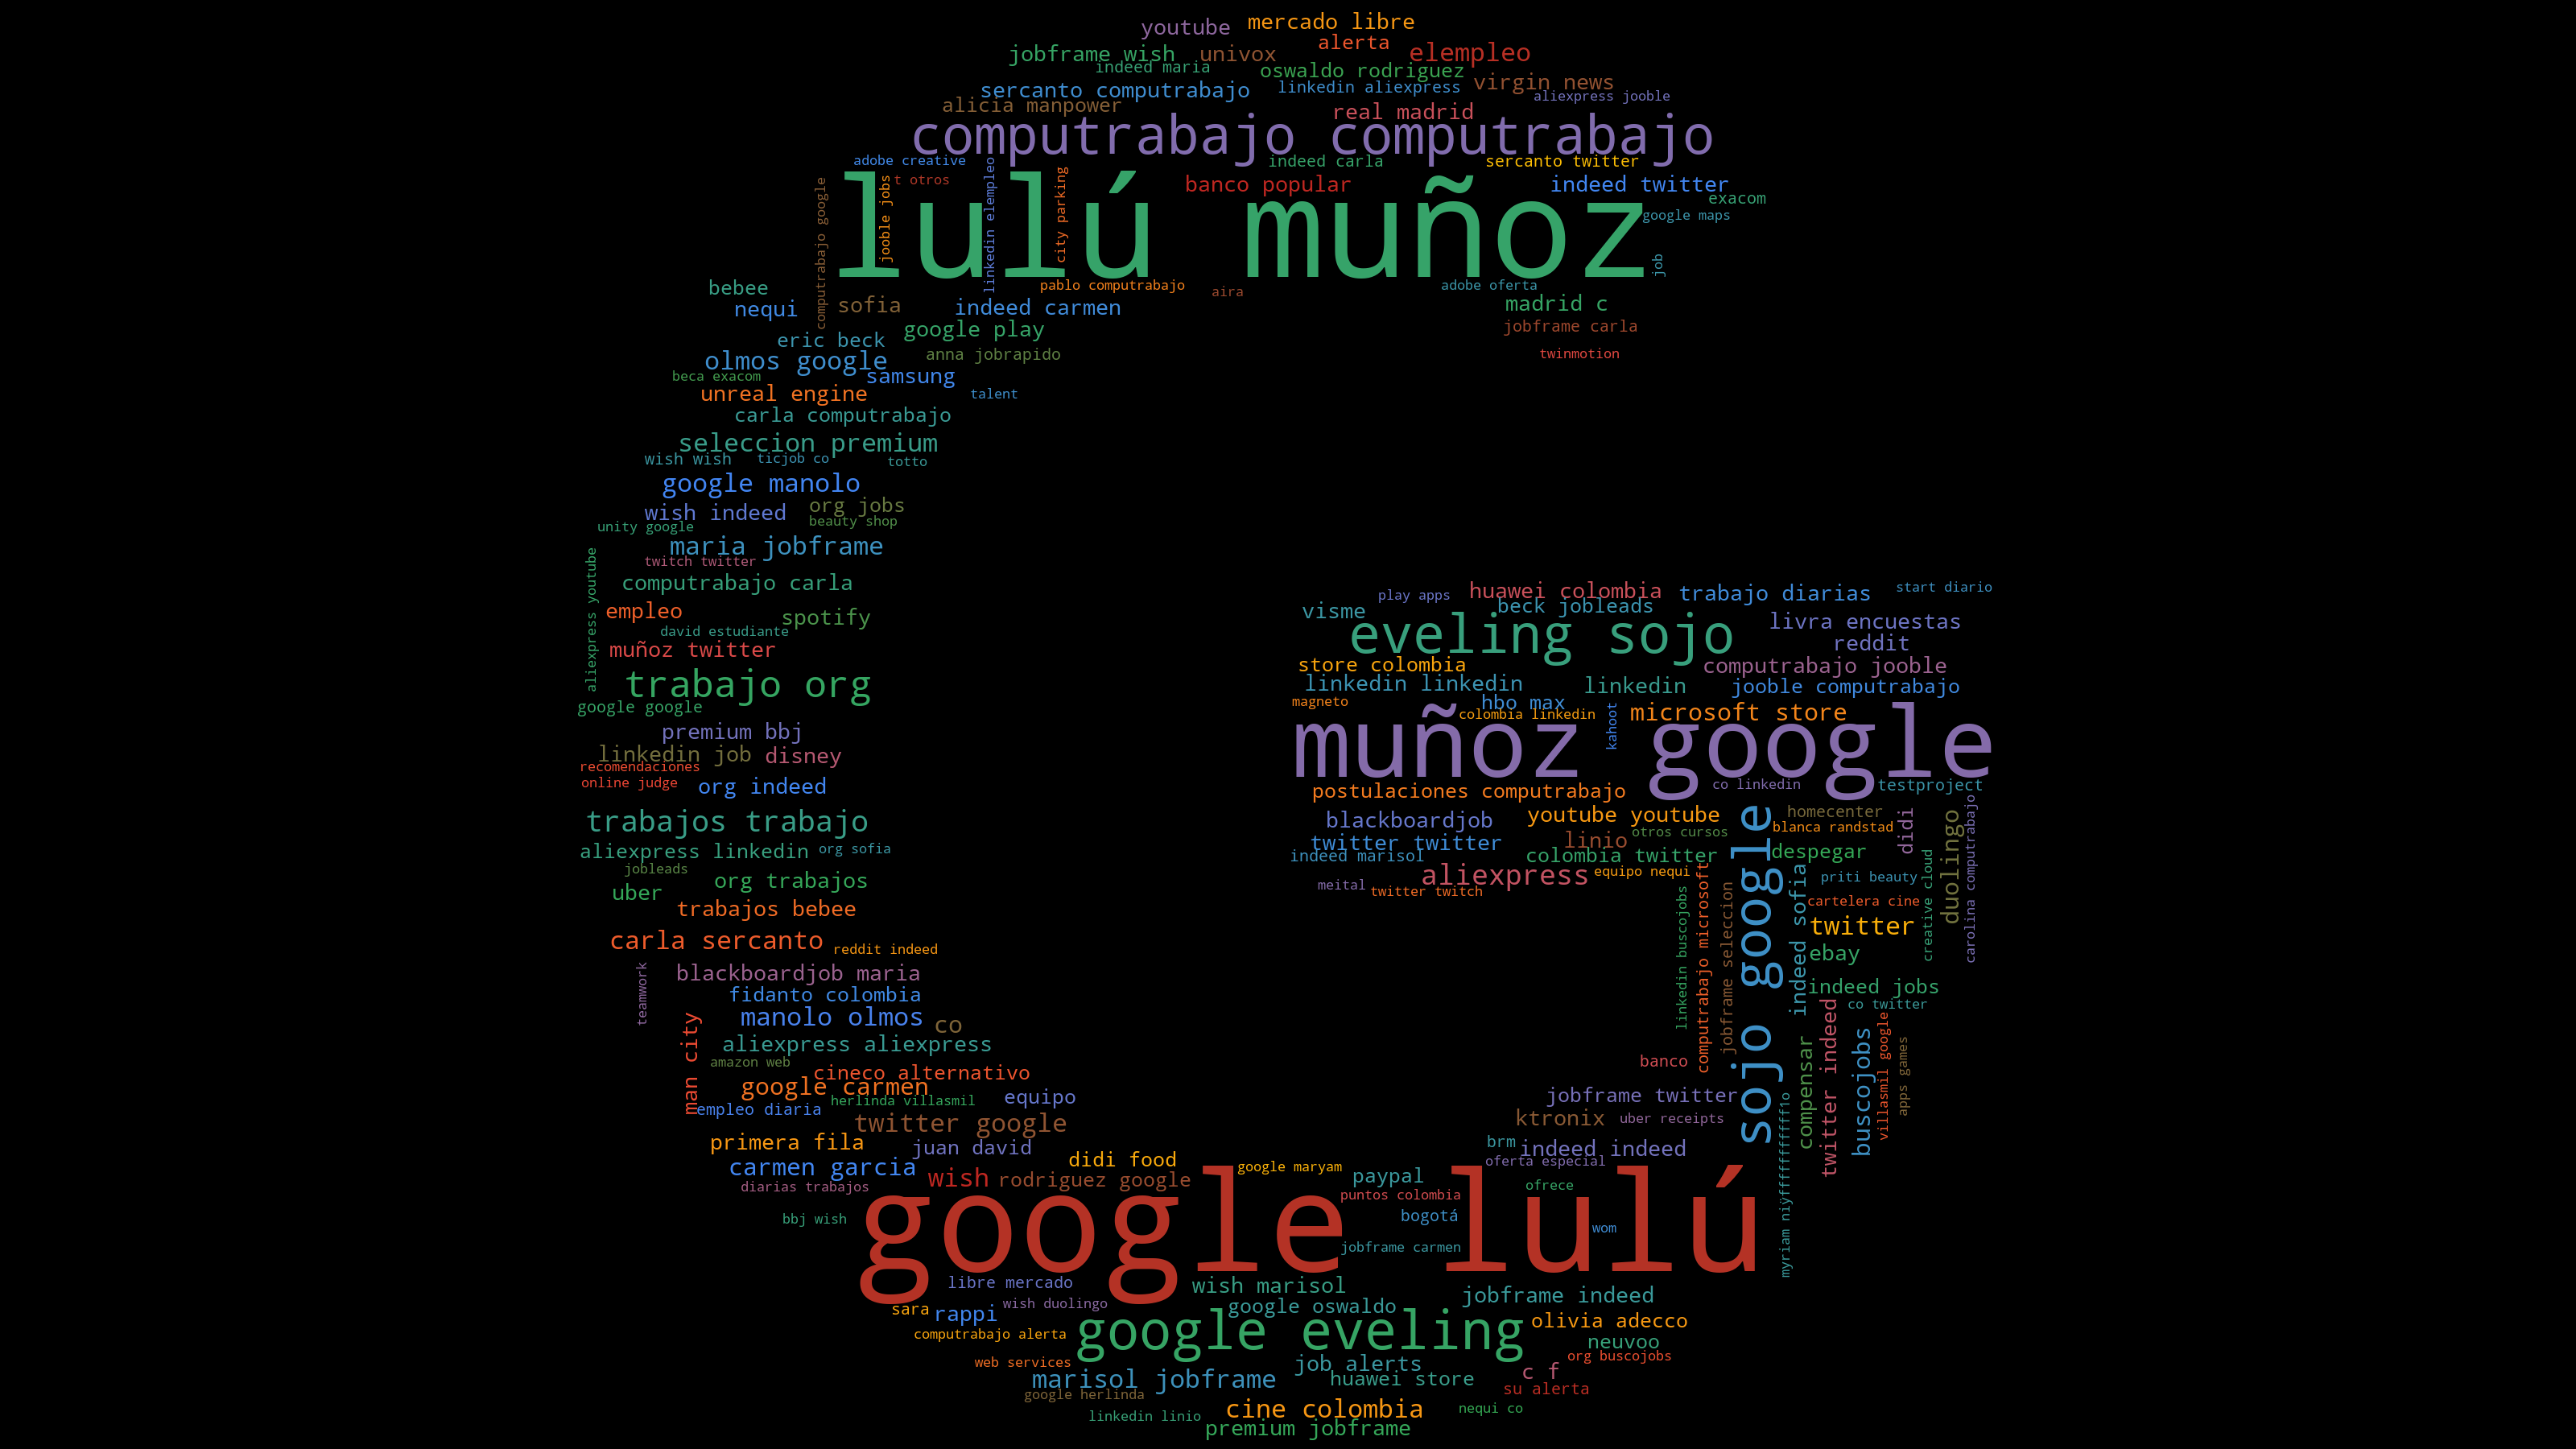

In [67]:
# Crear un string que contendrá todas las palabras
total_subjects = ' '
stopwords = STOPWORDS.update(['al','de','en','tu','s','la','y','que','te','lo','el','la','solo','del','por','qué','que','ha','desde',
                             'por','ya','más','es','con','tus','para','se','los','un','una','las','esto','va','sobre','ti','los',
                             'sandro','agama','está','tienes notificaciones','este','día','hola','hoy'])
mask = np.array(Image.open('C:/Users/user/Desktop/Data Analisis/Logo_Google.jpg'))

# Obtener y acumular todas los subjects de los correos
for mensaje in email_df['Name'].values:
    subjects = str(mensaje).lower().split() # Obtener las palabras en minúscula de cada subject
    for subject in subjects:
        total_subjects = total_subjects + subject + ' ' # Acumular todas los subjects

wordcloud = WordCloud(scale=2.5, width = 1000, height = 800, 
                      background_color ='black',
                      mask = mask,
                      colormap=gmail,
                      stopwords = stopwords, 
                      min_font_size = 6).generate(total_subjects) 

# Plotear la nube de palabras más usadas
wordcloud.to_image()